# Import Modules

In [3]:
from legacy_module.utils import simple_analysis, dataset_generator
from legacy_module.model import dense_basic
from torch.utils.data.dataloader import DataLoader
from torch import optim, nn, Tensor, LongTensor
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

print("PyTorch version:[%s]." % (torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:[%s]." % (device))

PyTorch version:[1.6.0].
device:[cuda:0].


# EDA


===== File analysis =====
Train Set Images: 2700
Test Set Images: 1800

===== CSV Label =====
          id  gender   race  age                    path
0     000001  female  Asian   45  000001_female_Asian_45
1     000002  female  Asian   52  000002_female_Asian_52
2     000004    male  Asian   54    000004_male_Asian_54
3     000005  female  Asian   58  000005_female_Asian_58
4     000006  female  Asian   59  000006_female_Asian_59
...      ...     ...    ...  ...                     ...
2695  006954    male  Asian   19    006954_male_Asian_19
2696  006955    male  Asian   19    006955_male_Asian_19
2697  006956    male  Asian   19    006956_male_Asian_19
2698  006957    male  Asian   20    006957_male_Asian_20
2699  006959    male  Asian   19    006959_male_Asian_19

[2700 rows x 5 columns]

Label is perfect!: 2700 / 2700

===== Label Data Analysis
female    1658
male      1042
Name: gender, dtype: int64

Asian    2700
Name: race, dtype: int64

<30          : 1281
>=30 and <60 : 1402

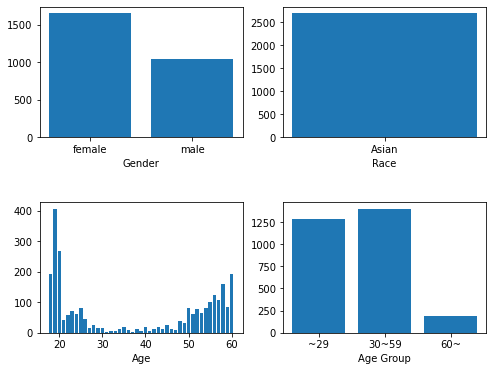

In [2]:
simple_analysis.run("/opt/ml/input/data")

# Load Data

In [ ]:
train_set = dataset_generator.generate_train_datasets("/opt/ml/input/data")
train_set_loader = DataLoader(train_set, batch_size=256)

# Model Define

In [ ]:
model = dense_basic.DenseBasic().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

if True:
    model.load_state_dict(torch.load("./result/last_model"))

# Training

In [ ]:
def convert_label(labels):
    results = []
    for label in labels:
        result = 0
        if label[2] == 0:
            result = 12
        elif label[3] == 0:
            result = 6
        else:
            result = 0
        
        if label[0] == 1:
            result += 3
        
        result += label[1]

        # results.append([1 if i == result else 0 for i in range(18)])
        results.append(result)

    return LongTensor(results)

In [ ]:
running_loss = 0.0
model.eval()
for index, (batch_source, batch_label) in tqdm(enumerate(train_set_loader), total=len(train_set_loader)):
    source = batch_source.to(device)
    labels = convert_label(batch_label).to(device)

    optimizer.zero_grad()

    outputs = model(source)
    
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if index % 5 == 4:
        print()
        print(f'loss: {running_loss / 5}')
        running_loss = 0.0
    
    if index % 25 == 24:
        torch.save(model.state_dict(), "./result/last_model")
        print("Model Saved")
    
torch.save(model.state_dict(), "./result/last_model")

# Test

In [ ]:
test_dataset = dataset_generator.generate_test_dataset("/opt/ml/input/data")
test_set_loader = DataLoader(test_dataset, batch_size=4)

In [ ]:
import pandas as pd
result = pd.DataFrame(columns=["ImageID", "ans"])

model.eval()
for index, (batch_source, batch_paths) in tqdm(enumerate(test_set_loader)):
    source = batch_source.to(device)

    outputs = model(source)

    for path, ans in zip(batch_paths, outputs):
        # print(ans)
        # print(ans.argmax(dim=0))
        row = {"ImageID": path, "ans": ans.argmax(dim=0).item()}
        result = result.append(row, ignore_index=True)

print(result)
result.to_csv("./result/result.csv")
    

    


(512, 384, 3)


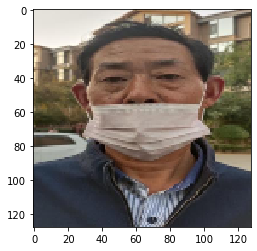

(512, 384, 3)


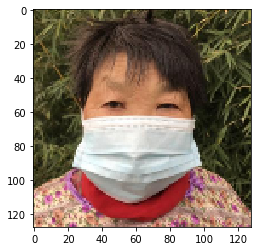

(512, 384, 3)


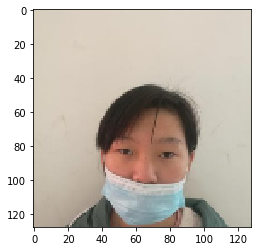

(512, 384, 3)


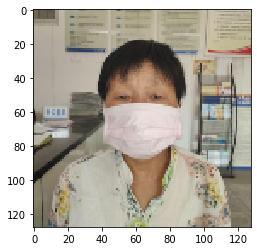

(512, 384, 3)


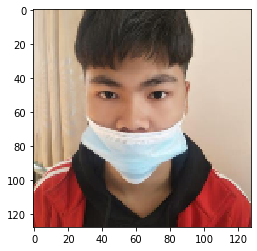

(512, 384, 3)


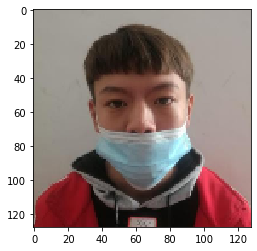

(512, 384, 3)


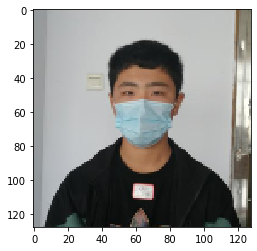

(512, 384, 3)


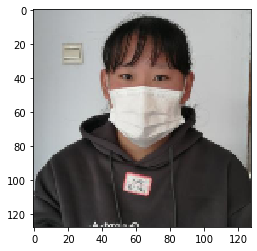

(512, 384, 3)


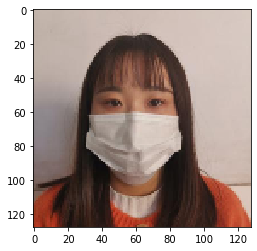

(512, 384, 3)


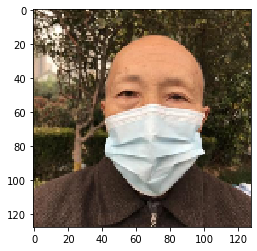

(512, 384, 3)


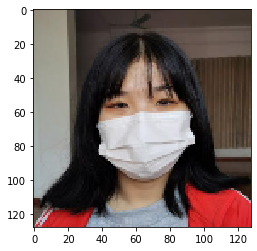

(512, 384, 3)


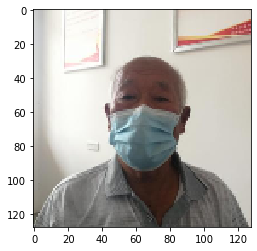

(512, 384, 3)


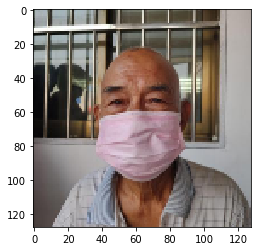

(512, 384, 3)


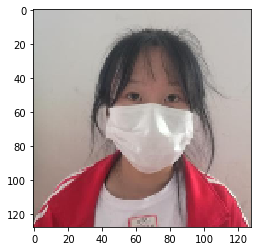

(512, 384, 3)


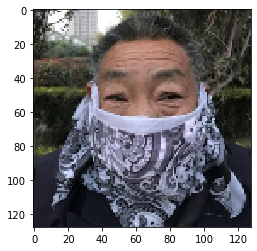

(512, 384, 3)


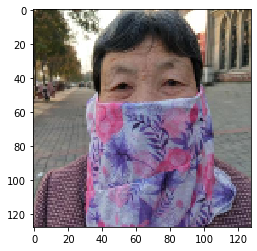

(512, 384, 3)


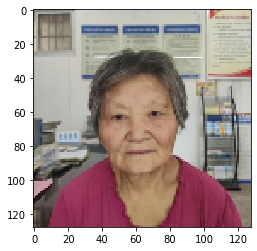

(512, 384, 3)


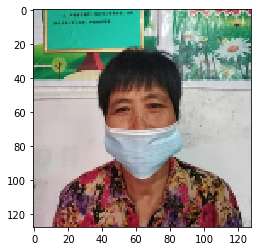

(512, 384, 3)


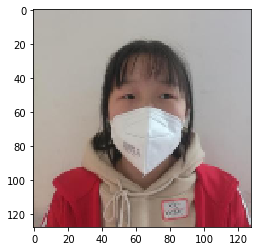

(512, 384, 3)


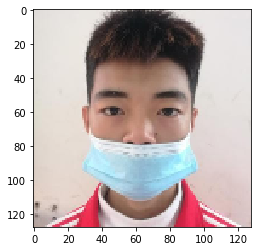

(512, 384, 3)


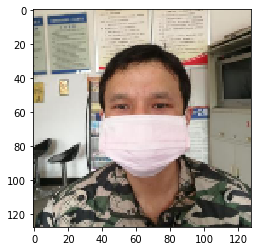

(512, 384, 3)


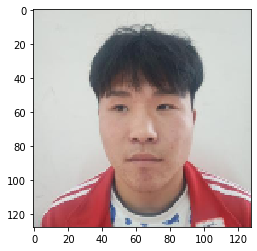

(512, 384, 3)


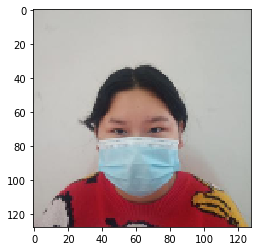

(512, 384, 3)


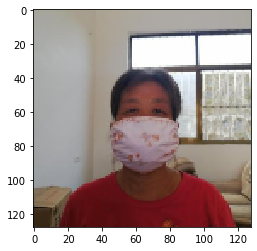

(512, 384, 3)


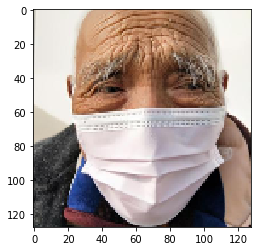

(512, 384, 3)


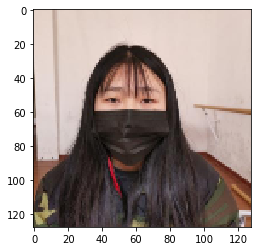

(512, 384, 3)


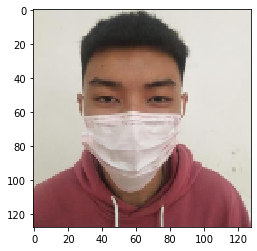

(512, 384, 3)


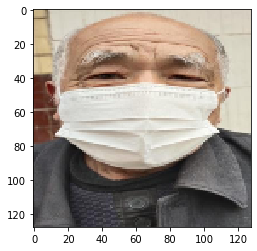

(512, 384, 3)


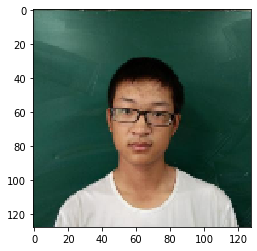

(512, 384, 3)


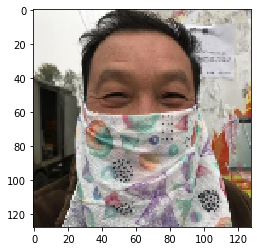

(512, 384, 3)


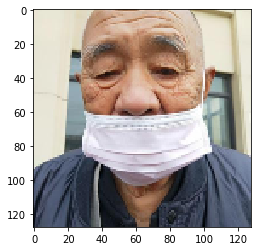

In [38]:
import albumentations as A
from albumentations.augmentations import SmallestMaxSize
import cv2 as cv
import matplotlib.pyplot as plt
from glob import glob

def show(path: str):
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    print(image.shape)
    min_length = 128
    transform = A.Compose([
        SmallestMaxSize(max_size=min_length, always_apply=True),
        A.CenterCrop(min_length, min_length, always_apply=True),
    ])
    new_image = transform(image=image)["image"]
    plt.imshow(new_image)
    plt.show()

data_root_path = "/opt/ml/input/data"
eval_images_path = glob(f"{data_root_path}/eval/images/*")

for index, image_path in enumerate(eval_images_path):
    if index > 239:
        show(image_path)
    if index == 270:
        break